In [ ]:
# Force Delete for non-empty dirs
import shutil
import os

folder_path = '/content/dataset'

# Check if the folder exists
if os.path.exists(folder_path):
    # Force delete the folder
    shutil.rmtree(folder_path)
    print(f'Folder {folder_path} has been deleted.')
else:
    print(f'Folder {folder_path} does not exist.')

Folder /content/dataset does not exist.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary library to download from Google Drive
!pip install gdown

# Download the ZIP file from Google Drive using the share URL
!gdown --id 1wHbHZY6m5guxde1ze-IedjY6eMqiwzOX

# Unzip the downloaded file
!unzip "FAE_D1_collated - use.zip" -d /content/dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_52 - Copy.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_52.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_55 - Copy.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_55.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_56 - Copy.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_56.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_6 - Copy.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_6.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_7 - Copy.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_7.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_8 - Copy.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_1_8.jpg  
  inflating: /content/dataset/FAE_D1_collated - use/51_0_2_1 - Copy.jpg  
  inflating: /content/d

In [ ]:
import os
import pandas as pd

data_path = '/content/dataset/FAE_D1_collated - use'
data = []

for filename in os.listdir(data_path):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        original_filename = filename

        # Clean up the filename
        filename = filename.strip().replace("-", "").replace(" ", "").replace("(", "").replace(")", "")

        try:
            # Extract information from the filename
            parts = filename.split('_')
            if len(parts) == 4:
                age, gender, zone, serial = parts
            elif len(parts) == 3:
                age, gender, zone = parts
                serial = ""
            else:
                print(f"Skipping file due to unexpected format: {filename}")
                continue

            # Convert extracted values
            age = int(age)
            gender = int(gender)
            zone = int(zone)

            # Prepare the image path and append data to the list
            image_path = os.path.join(data_path, original_filename)
            data.append({
                "image_path": image_path,
                'age': age,
                'gender': gender,
                'zone': max(zone - 1, 0),  # Ensure zone is zero-indexed
            })

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

df = pd.DataFrame(data)

# Function to check for NaNs and filter out invalid data
def check_for_nans(df):
    # Check and drop NaNs
    if df.isnull().values.any():
        print("NaN values found. Removing them...")
        df = df.dropna()

    # Validate and filter data ranges
    df = df[(df['age'] >= 0) &
            (df['gender'].isin([0, 1])) &
            (df['zone'] >= 0) & (df['zone'] < 6)]  # Assuming 0-5 is valid range for zones

    return df

# Apply validation
df = check_for_nans(df)

# Save the clean data to a CSV file
output_path = '/content/data.csv'
df.to_csv(output_path, index=False)
print("Data saved to CSV successfully.")


Data saved to CSV successfully.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Add,Dense, Dropout, Flatten, Concatenate, Input, BatchNormalization, Conv1D, MaxPooling2D,  MaxPooling1D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 6

                                          image_path  age  gender  \
0  /content/dataset/FAE_D1_collated - use/53_0_6_...   53       0   
1  /content/dataset/FAE_D1_collated - use/34_1_1_...   34       1   
2  /content/dataset/FAE_D1_collated - use/86_0_6_...   86       0   
3  /content/dataset/FAE_D1_collated - use/52_1_2_...   52       1   
4  /content/dataset/FAE_D1_collated - use/37_0_4_...   37       0   

            zone  
0     South West  
1  North Central  
2     South West  
3     North East  
4     South East  
+--------+---------+--------------------+--------------------+-----+------+------+------+-------+
|        |  count  |        mean        |        std         | min | 25%  | 50%  | 75%  |  max  |
+--------+---------+--------------------+--------------------+-----+------+------+------+-------+
|  age   | 30002.0 | 35.96166922205186  | 14.798034709350317 | 0.0 | 26.0 | 35.0 | 46.0 | 100.0 |
| gender | 30002.0 | 0.4214385707619492 | 0.4937977614049685 | 0.0 | 0.0  | 0.0

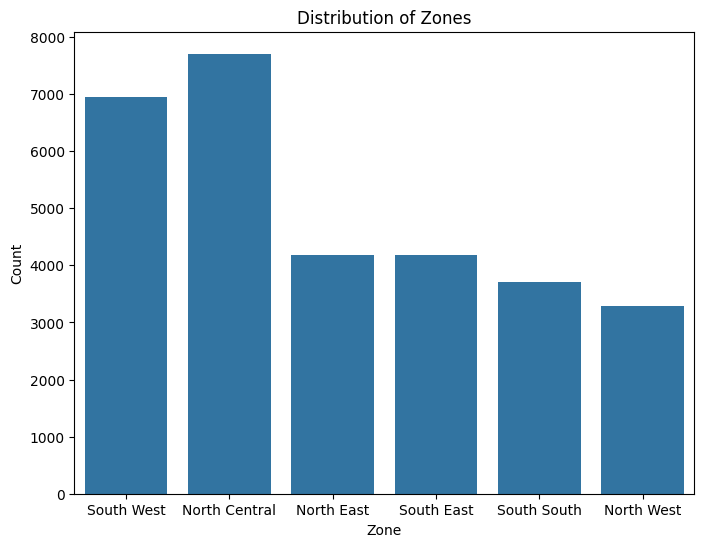

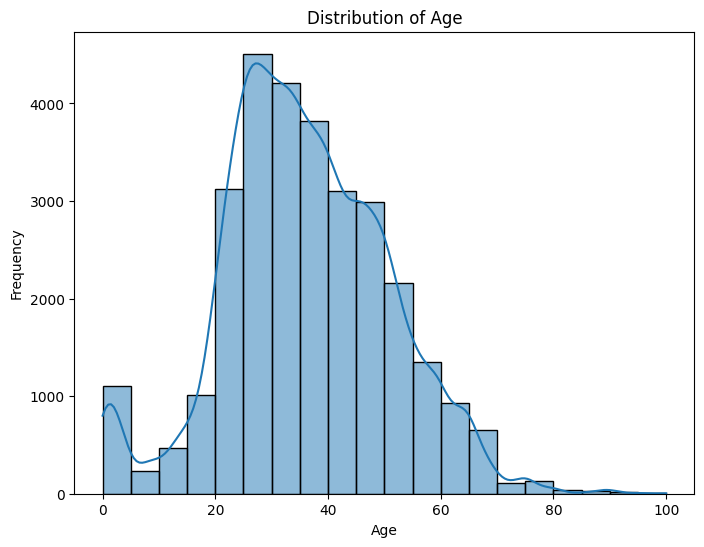

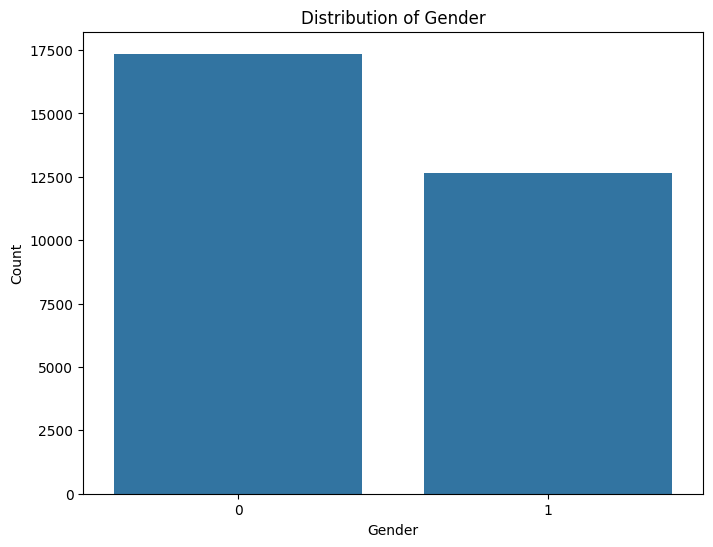

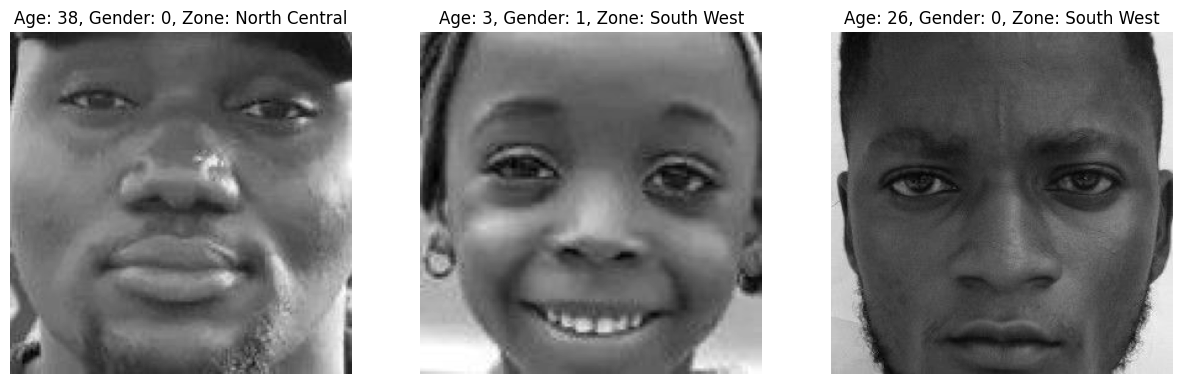

In [ ]:
import pandas as pd
from tabulate import tabulate
from enum import Enum, unique

@unique
class LabelClasses(str, Enum):
    NORTH_CENTRAL = "North Central"
    NORTH_EAST = "North East"
    NORTH_WEST = "North West"
    SOUTH_EAST = "South East"
    SOUTH_SOUTH = "South South"
    SOUTH_WEST = "South West"

# Function to load and preprocess data
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    return df

# Load and preprocess data
csv_path = '/content/data.csv'
df = load_data(csv_path)

# Map the numeric labels to zone names using .value
label_mapping = {
    0: LabelClasses.NORTH_CENTRAL.value,
    1: LabelClasses.NORTH_EAST.value,
    2: LabelClasses.NORTH_WEST.value,
    3: LabelClasses.SOUTH_EAST.value,
    4: LabelClasses.SOUTH_SOUTH.value,
    5: LabelClasses.SOUTH_WEST.value
}
df['zone'] = df['zone'].map(label_mapping)

# Display the first few rows
print(df.head())

# Remove image_path from statistics calculation
df_statistics = df.drop(columns=['image_path'])

# Display basic statistics in a pretty formatted table
stats_table = df_statistics.describe().transpose()
print(tabulate(stats_table, headers='keys', tablefmt='pretty'))

# Check for missing values in a pretty formatted table
missing_values = df_statistics.isnull().sum().reset_index()
missing_values.columns = ['Column', 'Missing Values']
print(tabulate(missing_values, headers='keys', tablefmt='pretty'))

# Calculate the number of images in each zone
zone_counts = df['zone'].value_counts().reset_index()
zone_counts.columns = ['Zone', 'Count']

# Display the zone counts in a pretty formatted table
print(tabulate(zone_counts, headers='keys', tablefmt='pretty'))

# Visualization code
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of zones
plt.figure(figsize=(8, 6))
sns.countplot(x='zone', data=df)
plt.title('Distribution of Zones')
plt.xlabel('Zone')
plt.ylabel('Count')
plt.show()

# Distribution of age
plt.figure(figsize=(8, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Distribution of gender
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=df)
plt.title('Distribution of Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

# Remove the contour (joint) plots as requested
# Removed jointplot for age and gender distribution

import cv2
import random

# Display a random image sample in grayscale
def display_random_images(df, data_path, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        random_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[random_idx]['image_path']
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale

        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Age: {df.iloc[random_idx]['age']}, Gender: {df.iloc[random_idx]['gender']}, Zone: {df.iloc[random_idx]['zone']}")
        plt.axis('off')

    plt.show()

# Display 5 sample images
display_random_images(df, csv_path, num_images=3)


In [ ]:

# Load dataset
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    return df

def preprocess_image(img_path):
    try:
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
    except tf.errors.InvalidArgumentError:
        print(f"Error reading or decoding image file: {img_path}")
        return None

    # Check if the image is empty or has invalid shape
    if img.shape[0] == 0 or img.shape[1] == 0:
        print(f"Empty image or invalid shape: {img_path}")
        return None

    img = tf.image.resize(img, IMG_SIZE)

    # Normalize image values to have a mean of 0 and a standard deviation of 1
    img = tf.image.per_image_standardization(img)

    # Optional: Add random data augmentation
    img = tf.image.random_flip_left_right(img)

    return img

# Prepare dataset for training
def prepare_dataset(df, batch_size):
    image_paths = df['image_path'].values
    ages = df['age'].values
    genders = df['gender'].values
    zones = df['zone'].values

    zone_mapping = {zone: i for i, zone in enumerate(df['zone'].unique())}
    zones_numerical = [zone_mapping[zone] for zone in zones]

    # Create a TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, ages, genders, zones))

    def load_and_preprocess_image(image_path, age, gender, zone):
        image = preprocess_image(image_path)
        return (image, age, gender), zone

    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE).repeat()

    return dataset


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Concatenate, Conv1D, BatchNormalization, MaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model


# Split into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['zone'])
valid_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['zone'])

# Create datasets
train_dataset = prepare_dataset(train_df, BATCH_SIZE)
valid_dataset = prepare_dataset(valid_df, BATCH_SIZE)
test_dataset = prepare_dataset(test_df, BATCH_SIZE)


# Create the ResNet50 base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the early layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Additional inputs
age_input = Input(shape=(1,), name='age')
gender_input = Input(shape=(1,), name='gender')

# Concatenate inputs
concat = Concatenate()([x, age_input, gender_input])

# Reduce Conv1D layers

# Convolutional layers with He Initialization
concat = tf.keras.layers.Reshape((-1, 1))(concat)
conv1 = Conv1D(64, kernel_size=3, activation='relu', kernel_initializer='he_normal')(concat)
conv1 = BatchNormalization()(conv1)
conv1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(128, kernel_size=3, activation='relu', kernel_initializer='he_normal')(conv1)
conv2 = BatchNormalization()(conv2)
conv2 = MaxPooling1D(pool_size=2)(conv2)

conv_flat = Flatten()(conv2)

# Dense layers with He Initialization
x = Dense(512, activation='relu', kernel_initializer='he_normal')(conv_flat)
x = BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

x = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='he_normal')(x)


# Define the model
model = Model(inputs=[base_model.input, age_input, gender_input], outputs=x)

# Print model summary to check parameter count
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 57,107,974 (217.85 MB)

 Trainable params: 33,518,854 (127.86 MB)

 Non-trainable params: 23,589,120 (89.99 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model definition
model = Model(inputs=[base_model.input, age_input, gender_input], outputs=x)

# Define optimizers
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.001, clipvalue=1.0)
nadam = Nadam(learning_rate=0.002)

# Early stopping callback and checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/zonecam/alpha.keras', monitor='val_loss', save_best_only=True, mode='min')

# Compile the model
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the number of parameters
print("Total parameters:", model.count_params())


Total parameters: 57107974


In [ ]:

# Train the model
model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=len(train_df) // BATCH_SIZE,
          validation_data=valid_dataset, validation_steps=len(valid_df) // BATCH_SIZE, callbacks=[])




Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 107s 119ms/step - accuracy: 0.2314 - loss: 2.0036 - val_accuracy: 0.2802 - val_loss: 1.6839
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 94s 118ms/step - accuracy: 0.2858 - loss: 1.6771 - val_accuracy: 0.2901 - val_loss: 1.6786
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.3051 - loss: 1.6479 - val_accuracy: 0.2995 - val_loss: 1.6697
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 113ms/step - accuracy: 0.3122 - loss: 1.6275 - val_accuracy: 0.2692 - val_loss: 2.1154
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 83s 111ms/step - accuracy: 0.3276 - loss: 1.6047 - val_accuracy: 0.2807 - val_loss: 1.8697
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 113ms/step - accuracy: 0.3362 - loss: 1.5800 - val_accuracy: 0.2874 - val_loss: 2.1052
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 84s 112ms/step - accuracy: 0.3628 - loss: 1.5569 - val_accuracy: 0.3393 - val_loss: 1.5931
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 85s 113ms/step - accuracy: 0.3703 - loss: 

KeyboardInterrupt: 

In [ ]:
# save model
model.save('/content/drive/MyDrive/zonecam/main.keras')

In [2]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/drive/MyDrive/zonecam/main.keras')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, mean_absolute_error
import tensorflow as tf

# Evaluate the model
num_test_samples = len(test_df)
test_steps = num_test_samples // BATCH_SIZE
test_loss, test_acc = model.evaluate(test_dataset, steps=test_steps)


937/937 ━━━━━━━━━━━━━━━━━━━━ 85s 90ms/step - accuracy: 0.4315 - loss: 1.8632


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

<ipython-input-54-6ddb9555d5d1>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(zone_labels_dict.values()), y=correct_predictions_percentage, palette='viridis')


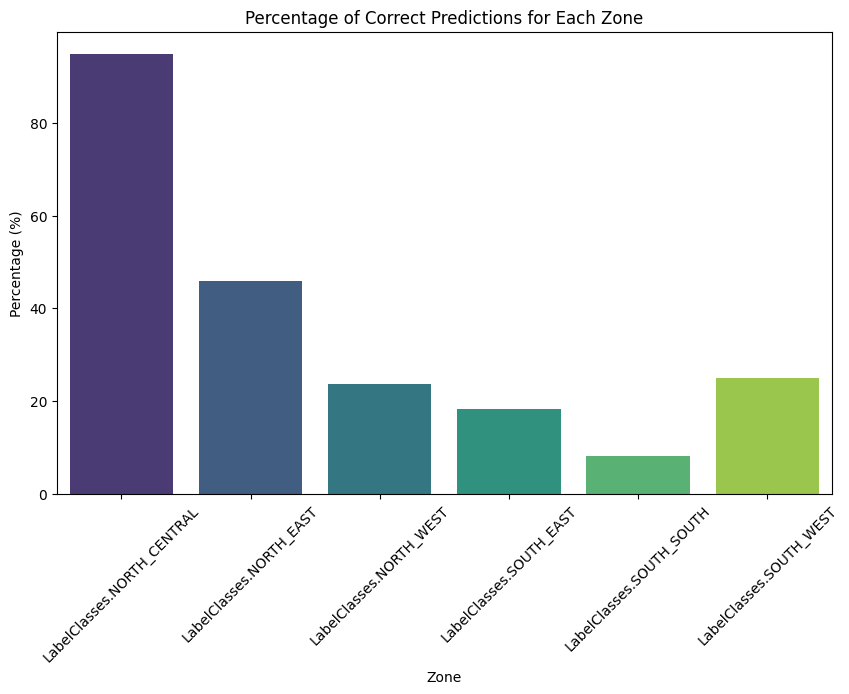

KeyError: 'accuracy'

In [ ]:

# Display Mean Absolute Error
y_true = []
y_pred = []

for (images, ages, genders), zones in test_dataset.take(test_steps):
    # Collect true labels
    y_true.extend(zones.numpy())

    # Make predictions
    predictions = model.predict([images, ages, genders])
    y_pred.extend(np.argmax(predictions, axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

mae = mean_absolute_error(y_true, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")

# Correct predictions percentage for each zone
zone_labels = list(LabelClasses)
zone_labels_dict = {i: label for i, label in enumerate(zone_labels)}

correct_predictions = np.array(y_true) == np.array(y_pred)
correct_predictions_percentage = [np.mean(correct_predictions[y_true == i]) * 100 for i in range(len(zone_labels))]

plt.figure(figsize=(10, 6))
sns.barplot(x=list(zone_labels_dict.values()), y=correct_predictions_percentage, palette='viridis')
plt.title('Percentage of Correct Predictions for Each Zone')
plt.xlabel('Zone')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.show()





1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


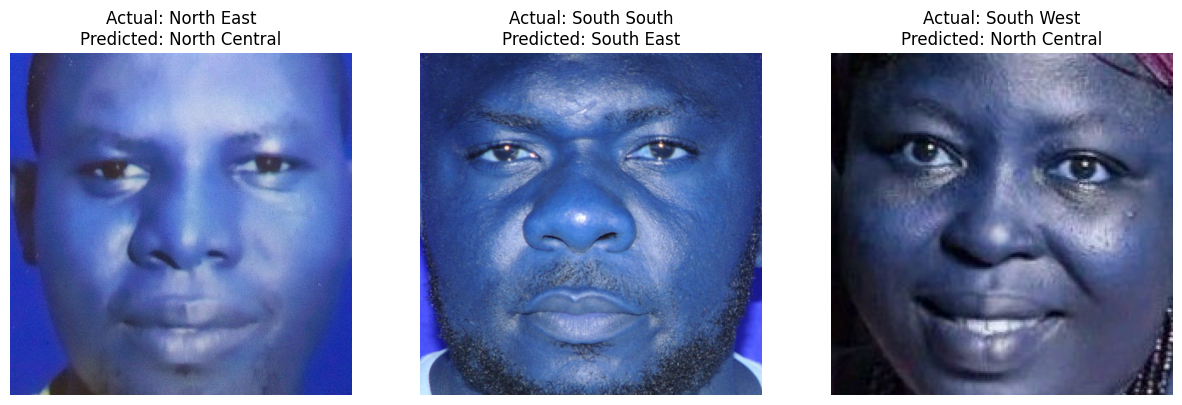

F1 Score: 0.3807


In [ ]:
# Show 3 random sample predictions
sample_indices = np.random.choice(len(test_df), 3, replace=False)
plt.figure(figsize=(15, 5))

for i, idx in enumerate(sample_indices):
    img_path = test_df.iloc[idx]['image_path']
    true_zone = test_df.iloc[idx]['zone']
    true_zone_label = zone_labels_dict[true_zone]

    img = plt.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image to RGB if necessary

    # Preprocess the image to match the model's input format
    img_processed = preprocess_image(img_path)
    img_processed = tf.expand_dims(img_processed, axis=0)  # Add batch dimension

    # Assuming 'age' and 'gender' are columns in your test_df DataFrame
    age = tf.convert_to_tensor([test_df.iloc[idx]['age']])
    gender = tf.convert_to_tensor([test_df.iloc[idx]['gender']])

    # Pass all three inputs to the model
    pred = model.predict([img_processed, age, gender])
    predicted_zone = np.argmax(pred)
    predicted_zone_label = zone_labels_dict[predicted_zone]

    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')  # Display image in grayscale
    plt.title(f"Actual: {true_zone_label}\nPredicted: {predicted_zone_label}")
    plt.axis('off')

plt.show()

# Compute and display F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

In [6]:
!pip install pillow

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
import cv2
from PIL import Image
import io
import base64

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          // Resize the output to fit the video element.
          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

          // Wait for Capture to be clicked.
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();

          return new Promise((resolve) => {
              canvas.toBlob((blob) => {
                  const reader = new FileReader();
                  reader.readAsDataURL(blob);
                  reader.onloadend = () => {
                      const base64data = reader.result;
                      resolve(base64data);
                  }
              }, 'image/jpeg', quality);
          });
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = base64.b64decode(data.split(',')[1])

    # Process the image data
    image = Image.open(io.BytesIO(binary))
    image.save(filename)
    return filename

<IPython.core.display.Javascript object>

Enter age: 22
Enter gender (0 for female, 1 for male): 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


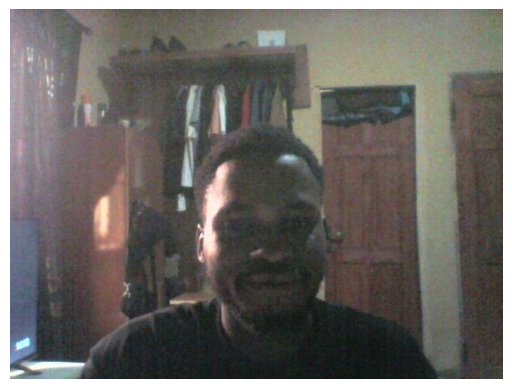

Predicted Geopolitical Zone: North Central


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from PIL import Image

# Example mapping of zones to labels
zone_labels = {
    0: "North Central",
    1: "North East",
    2: "North West",
    3: "South East",
    4: "South South",
    5: "South West"
}

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to predict geopolitical zone
def predict_zone(model, img_array, age, gender):
    age_array = np.array([[age]])
    gender_array = np.array([[gender]])

    preds = model.predict([img_array, age_array, gender_array])
    predicted_class = np.argmax(preds, axis=1)[0]

    return predicted_class

# Function to display and predict
def predict_geopolitical_zone_from_camera(model):
    # Capture image from the webcam
    img_path = take_photo(filename='captured_image.jpg')

    # Collect age and gender
    age = int(input("Enter age: "))
    gender = int(input("Enter gender (0 for female, 1 for male): "))

    # Load and preprocess the image
    img_array = load_and_preprocess_image(img_path)

    # Predict the zone
    predicted_zone = predict_zone(model, img_array, age, gender)

    # Map the predicted zone to its label name
    predicted_zone_label = zone_labels.get(predicted_zone, "Unknown Zone")

    # Display the image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Output the predicted zone label
    print(f"Predicted Geopolitical Zone: {predicted_zone_label}")

# Call the function to predict using webcam input
predict_geopolitical_zone_from_camera(model)
